In [2]:
from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = read_excel("../../gradeuate.xlsx")
origin.head()


,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [4]:
origin.isna().sum()

합격여부    0
필기점수    0
학부성적    0
병원경력    0
dtype: int64

In [5]:
origin['합격여부'] = origin['합격여부'].astype('category')
origin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   합격여부    400 non-null    category
 1   필기점수    400 non-null    int64   
 2   학부성적    400 non-null    float64 
 3   병원경력    400 non-null    int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 10.0 KB


In [6]:
origin.describe()


,필기점수,학부성적,병원경력
count,400.000000,400.000000,400.00000
mean,587.700000,3.389900,2.48500
std,115.516536,0.380567,0.94446
min,220.000000,2.260000,1.00000
25%,520.000000,3.130000,2.00000
50%,580.000000,3.395000,2.00000
75%,660.000000,3.670000,3.00000
max,800.000000,4.000000,4.00000


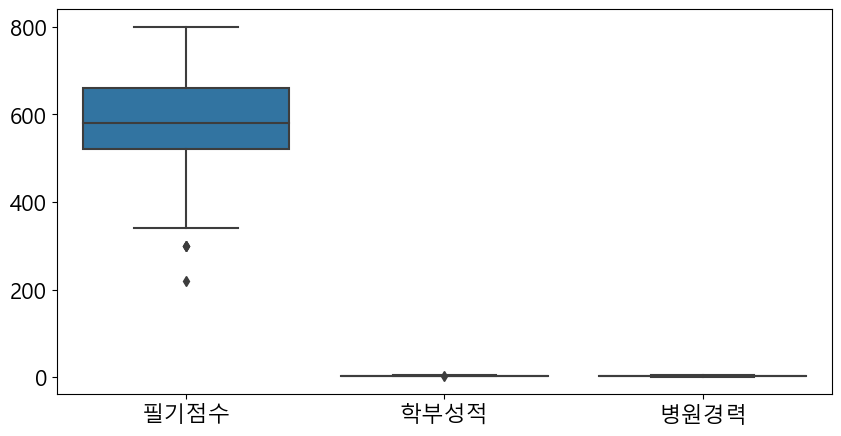

In [7]:
plt.figure(figsize=(10,5))
sb.boxplot(data = origin)
plt.show()
plt.close()

> 데이터 단위가 크게 차이가 나므로 표준화 필요

## 05. 데이터셋 분할하기
#### 랜덤시드 고정

In [8]:
np.random.seed(777)


#### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [9]:
x = origin[['필기점수', '학부성적', '병원경력']]
y = origin[['합격여부']]
x.shape, y.shape

((400, 3), (400, 1))

#### 데이터 표준화


In [10]:
x_scaler = StandardScaler()
x_scale = x_scaler.fit_transform(x)
print(x_scale.shape)
x_scale

(400, 3)


array([[-1.80026271,  0.57907192,  0.54596793],
       [ 0.62666824,  0.73692942,  0.54596793],
       [ 1.84013372,  1.60514289, -1.57429586],
       ...,
       [-1.10685387, -1.99925902, -0.51416397],
       [ 0.97337266,  0.68431046, -0.51416397],
       [ 0.10661161,  1.31573861,  0.54596793]])

#### 표준화 전 후 상자 그림 비교 

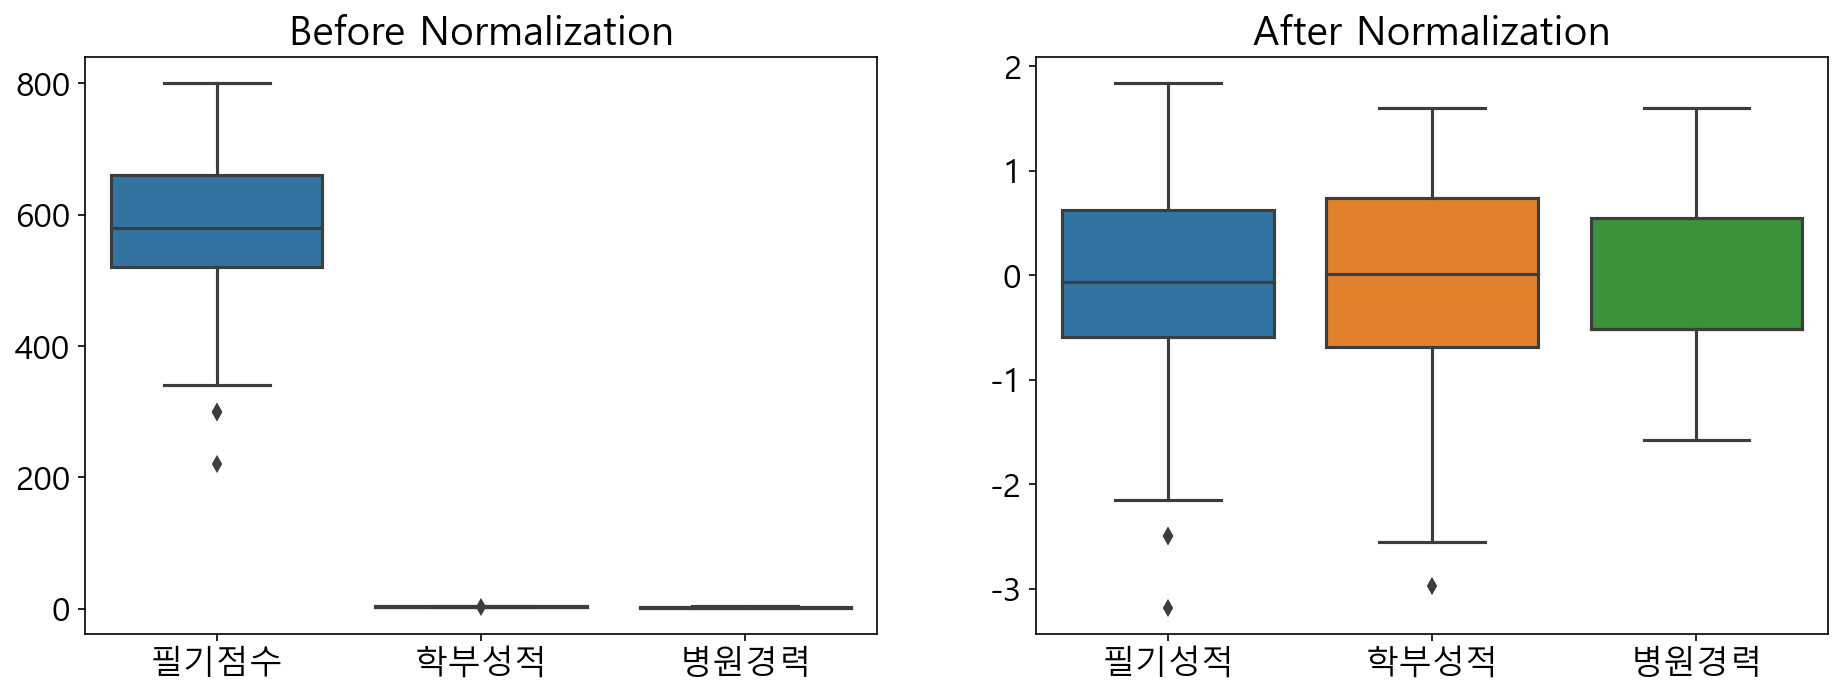

In [11]:
x_scale_df = DataFrame(x_scale, columns = ['필기성적', '학부성적', '병원경력'])

fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 150)
sb.boxplot(data = origin, ax= ax[0])
sb.boxplot(data = x_scale_df, ax = ax[1])
ax[0].set_title('Before Normalization')
ax[1].set_title("After Normalization")
plt.show()
plt.close()

#### 훈련 데이터와 검증 데이터로 분할

In [12]:
x_train, x_test, y_train, y_test= train_test_split(x_scale,y, test_size = 0.3, random_state= 777)
x_train.shape, x_test.shape ,y_train.shape, y_test.shape

((280, 3), (120, 3), (280, 1), (120, 1))

## 06. 모델 개발
#### 모델 정의
[relu,] sigmoid rmsporp binary_crossentropy acc

In [13]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape  = (3, )))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 학습하기

In [14]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test,y_test), callbacks = [
            EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.5, min_lr = 0.0001, verbose = 1)
])

Epoch 1/500
9/9 [==============================] - 0s 17ms/step - loss: 0.7130 - acc: 0.4821 - val_loss: 0.7242 - val_acc: 0.5167 - lr: 0.0010
Epoch 2/500
9/9 [==============================] - 0s 3ms/step - loss: 0.6907 - acc: 0.5429 - val_loss: 0.7008 - val_acc: 0.5833 - lr: 0.0010
Epoch 3/500
9/9 [==============================] - 0s 7ms/step - loss: 0.6761 - acc: 0.6071 - val_loss: 0.6823 - val_acc: 0.6417 - lr: 0.0010
Epoch 4/500
9/9 [==============================] - 0s 4ms/step - loss: 0.6643 - acc: 0.6357 - val_loss: 0.6665 - val_acc: 0.7083 - lr: 0.0010
Epoch 5/500
9/9 [==============================] - 0s 4ms/step - loss: 0.6548 - acc: 0.6571 - val_loss: 0.6528 - val_acc: 0.7000 - lr: 0.0010
Epoch 6/500
9/9 [==============================] - 0s 4ms/step - loss: 0.6470 - acc: 0.6643 - val_loss: 0.6412 - val_acc: 0.7083 - lr: 0.0010
Epoch 7/500
9/9 [==============================] - 0s 4ms/step - loss: 0.6399 - acc: 0.6750 - val_loss: 0.6303 - val_acc: 0.7000 - lr: 0.0010
Epoch

## 07. 학습 결과 평가

In [15]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace= True)    



In [16]:
result_df.columns[0]

'loss'

In [17]:
train_column_name = [result_df.columns[0], result_df.columns[1]]
test_column_name = [result_df.columns[2], result_df.columns[3]]

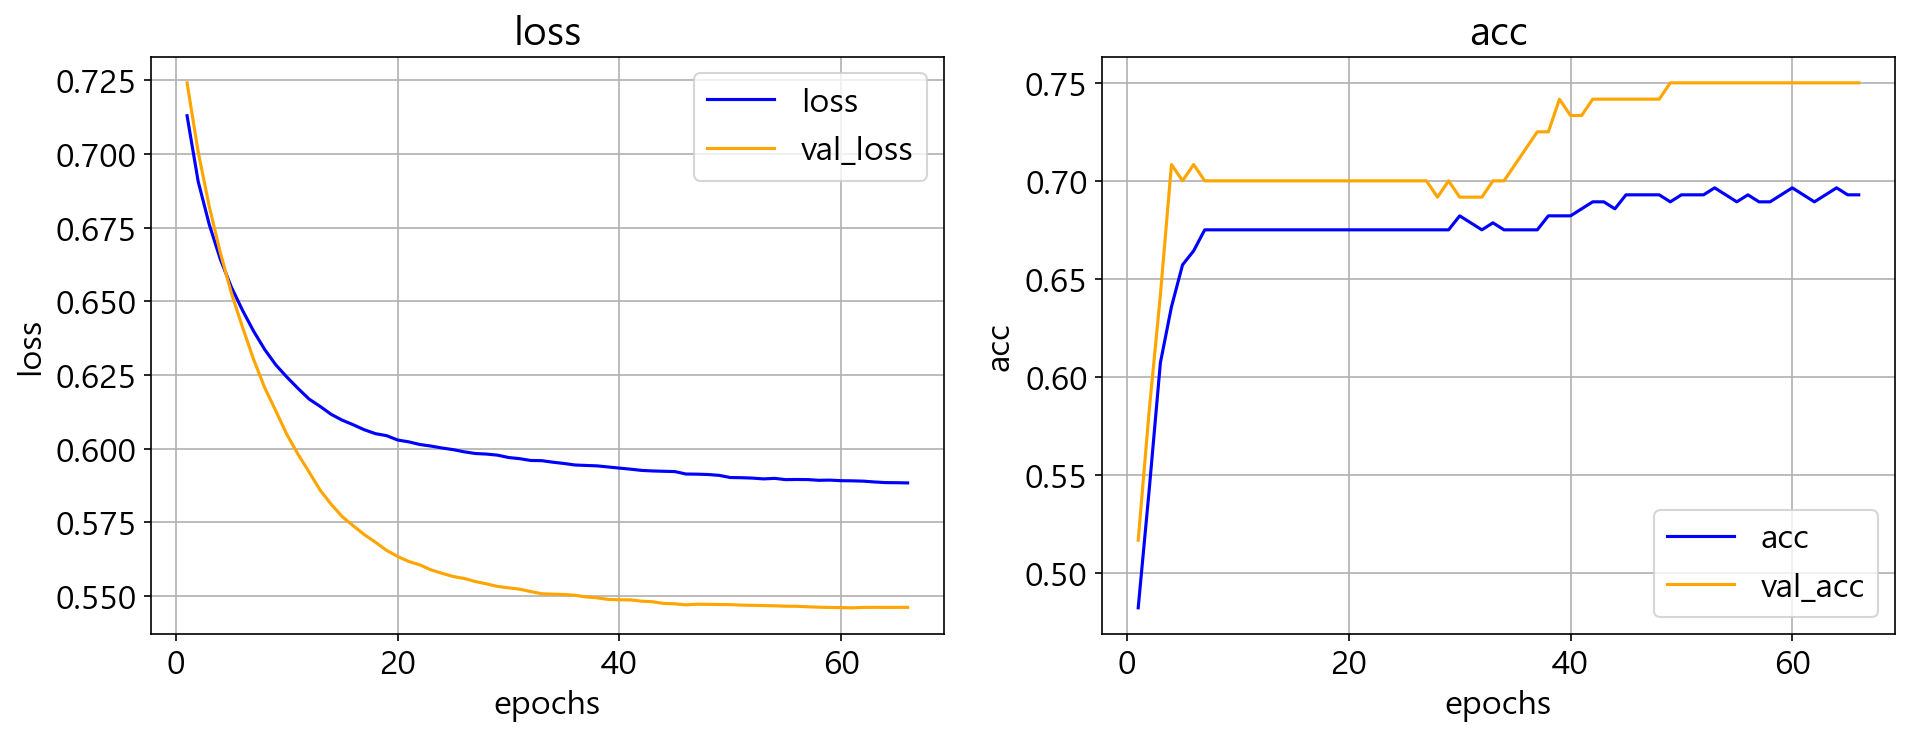

In [18]:
fig, ax = plt.subplots(1,2, figsize =(15,5), dpi = 150)
for i, v in enumerate(ax):
    sb.lineplot(x = result_df.index, y = train_column_name[i], data = result_df,  color = 'blue', label = train_column_name[i], ax =v)
    sb.lineplot(x = result_df.index, y = test_column_name[i], data = result_df, color = 'orange', label = test_column_name[i], ax =v)
    v.set_title(train_column_name[i])
    v.set_xlabel('epochs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()
plt.show()
plt.close()

In [19]:
evaluate1 =model.evaluate(x_train, y_train)
print('최종 훈련 손실율: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print('최종 검증 손실율: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

9/9 [==============================] - 0s 1ms/step - loss: 0.5880 - acc: 0.6929
최종 훈련 손실율: 0.588045, 최종 훈련 정확도: 0.692857
4/4 [==============================] - 0s 1ms/step - loss: 0.5461 - acc: 0.7500
최종 검증 손실율: 0.546148, 최종 검증 정확도: 0.750000


## 08. 학습 결과 적용
#### 훈련 데이터에 대한 예측 결과 산정

In [20]:
train_pred = model.predict(x_train)
data_count, case_count = train_pred.shape
print("%d개의 훈련 데이터가 %d개 경우의 수를 갖는다." % (data_count, case_count))


9/9 [==============================] - 0s 1ms/step
280개의 훈련 데이터가 1개 경우의 수를 갖는다.


#### 검증 데이터에 대한 예측 결과 산정

In [21]:
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))


4/4 [==============================] - 0s 1000us/step
120개의 검증 데이터가 1개의 경우의 수를 갖는다.


#### 결과 데이터 셋 구성

In [22]:
test_pred

array([[0.2904998 ],
       [0.27694154],
       [0.21383002],
       [0.23849301],
       [0.4593525 ],
       [0.17191541],
       [0.47654238],
       [0.12948352],
       [0.3190421 ],
       [0.46003446],
       [0.5216609 ],
       [0.25761777],
       [0.14047524],
       [0.42912096],
       [0.40027228],
       [0.3291667 ],
       [0.50394154],
       [0.32444692],
       [0.42257965],
       [0.18201064],
       [0.16660506],
       [0.34403026],
       [0.33254844],
       [0.17486078],
       [0.3338157 ],
       [0.4529897 ],
       [0.1622624 ],
       [0.45355144],
       [0.35972127],
       [0.44034317],
       [0.26290563],
       [0.05489486],
       [0.2396991 ],
       [0.3284465 ],
       [0.37786672],
       [0.32939833],
       [0.21443619],
       [0.33122233],
       [0.2924714 ],
       [0.2834994 ],
       [0.21211506],
       [0.34654233],
       [0.42988038],
       [0.44439375],
       [0.45439816],
       [0.14614224],
       [0.15705954],
       [0.188

In [23]:
threshold = 0.4
test_score = (test_pred >= threshold).astype(int)
kdf = DataFrame({
    '결과값' : y_test['합격여부'].values, 
    "예측치" : np.round(test_score.flatten()), #dimension 1로 만든다.
    "합격확률(%)" : np.round(test_pred.flatten() * 100, 1)
})
kdf

,결과값,예측치,합격확률(%)
0,0,0,29.000000
1,1,0,27.700001
2,1,0,21.400000
3,1,0,23.799999
4,1,1,45.900002
...,...,...,...
115,1,0,37.200001
116,1,0,22.100000
117,1,0,27.600000
118,0,0,10.700000


#### 혼동행렬

In [24]:
cm = confusion_matrix(kdf['결과값'], kdf['예측치'])
tn, fp, fn, tp = cm.ravel()
print(tp,fp,fn,tn)
cmdf = DataFrame([ [ tp , fn ], [fp, tn]], index =[["Predicted Values","Predicted Values"],['Positive', "Negative"]], columns = [["Actual Values","Actual Values"],["Positive", "Negative"]])
cmdf

23 21 13 63


Actual Values         
                               Positive Negative
Predicted Values Positive            23       13
                 Negative            21       63

|구분|	설명|
|---|---|
|TN(True Negative, Negative Negative)	| 실제는 Negative인데, Negative로 예측함.|
|FP(False Positive, Negative Positive)	|실제는 Negative인데, Positive로 예측함. (Type1 Error)|
|FN(False Negative, Positive Negative) | 실제는 Positive인데, Negative로 예측함. (Type2 Error)|
|TP(True Positive, Positive Positive) | 실제는 Positive인데, Positive로 예측함.|

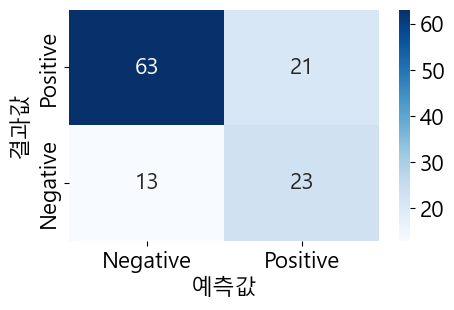

In [25]:
plt.figure(figsize = (5,3))
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (<https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html>)
sb.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xticks([0.5, 1.5], ["Negative", "Positive"])
plt.yticks([0.5, 1.5], ['Positive',"Negative"])
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

#### 평가지표

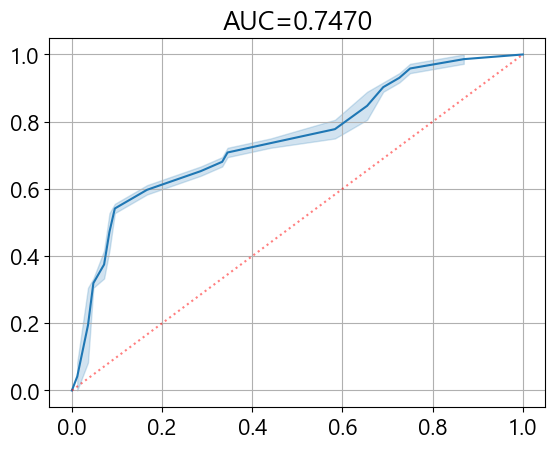

In [26]:
ras = roc_auc_score(kdf['결과값'], test_pred.flatten())
# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(kdf['결과값'], test_pred.flatten())

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()


In [27]:
#정확도
acc = accuracy_score(kdf['결과값'], test_score)

# 정밀도
pre = precision_score(kdf['결과값'], test_score)

# 재현율
recall = recall_score(kdf['결과값'], test_score)

# F1 score
f1 = f1_score(kdf['결과값'], test_score)

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

result_df

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.716667,0.522727,0.638889,0.25,0.75,0.747024,0.575


#### 분류 보고서

- precision: 정밀도(분류기가 참으로 분류한 항목 중에서 실제 데이터가 참인 비율)
- recall : 재현율 (실제 참 중에서 분류기가 참으로 분류한 비율)
- f1-score : 2(Recall $\times$ Precision) / (Recall + Precision)
    - Precision과 Recall의 조화평균
    - 주로 분류 클래스 간 데이터가 심각한 불균형을 이루는 경우에 사용
    - 정확도의 경우, 클래스가 데이터 분류가 균일하지 못하면 머신의 성능을 제대로 나타내줄 수 없기 때문에 F1을 사용한다.
- support: 전체 데이터 수

In [28]:
report = classification_report(kdf['결과값'], test_score)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        84
           1       0.52      0.64      0.57        36

    accuracy                           0.72       120
   macro avg       0.68      0.69      0.68       120
weighted avg       0.74      0.72      0.72       120

